# k-Nearest Neighbor (kNN)

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

### Importing required libraries

In [77]:
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import platform

In [78]:
# ipynb parameters

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
# funcs to load datasets

def load_pickle(f):
    version = platform.python_version_tuple()

    if version[0] == "2":
        return pickle.load(f)
    elif version[0] == "3":
        return pickle.load(f, encoding="latin1")

    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):

    with open(filename, "rb") as f:
        datadict = load_pickle(f)
        X = datadict["data"]
        Y = datadict["labels"]
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(dataset_path):    
    xs, ys = [], []

    for batch_id in range(1, 6):
        f = os.path.join(dataset_path, "data_batch_%d" % (batch_id,))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)

    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)

    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(dataset_path, "test_batch"))

    return Xtr, Ytr, Xte, Yte


In [80]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'datasets/cifar-10-batches-py'
x_train, y_train, x_test, y_test = load_CIFAR10(cifar10_dir)

print('Training data shape: ', x_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


### Visulaizing the dataset

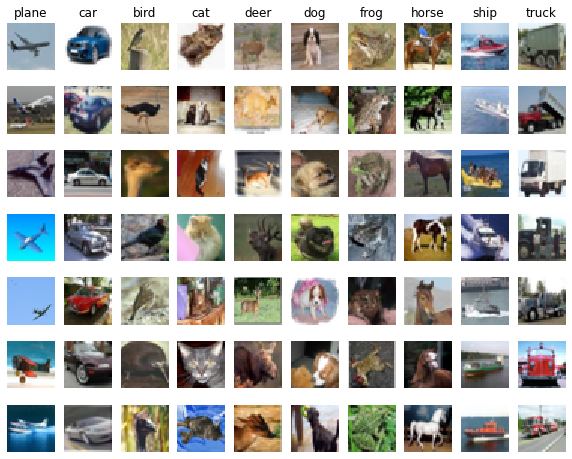

In [81]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7

for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [82]:
# for faster processing we are using only part of the dataset
# 5000 training images data
x_train = x_train[:5000]
y_train = y_train[:5000]

# 500 training images data
x_test = x_test[:500]
y_test = y_test[:500]

# Reshape the image data into rows
x_train = np.reshape(x_train, (x_train.shape[0], -1))
x_test = np.reshape(x_test, (x_test.shape[0], -1))

print('Training data shape: ', x_train.shape)
print('Test data shape: ', x_test.shape)

Training data shape:  (5000, 3072)
Test data shape:  (500, 3072)


## K-NN Classifier

In [83]:
class KNearestNeighbor(object):
  """ a kNN classifier with L2 distance """

  def __init__(self):
    pass

  def train(self, X, y):
    """
    Train the classifier. For k-nearest neighbors this is just memorizing the training data.

    Inputs:
    - X: A numpy array of shape (num_train, D) containing the training data consisting of num_train samples each of dimension D.
    - y: A numpy array of shape (N,) containing the training labels, where y[i] is the label for X[i].
    """
    self.x_train = X
    self.y_train = y

  def predict(self, X, k=1, num_loops=0):
    """
    Predict labels for test data using this classifier.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data consisting
          of num_test samples each of dimension D.
    - k: The number of nearest neighbors that vote for the predicted labels.
    - num_loops: Determines which implementation to use to compute distances
      between training points and testing points.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].
    """
    if num_loops == 0:
        dists = self.compute_distances_no_loops(X)
    elif num_loops == 1:
        dists = self.compute_distances_one_loop(X)
    elif num_loops == 2:
        dists = self.compute_distances_two_loops(X)
    else:
        raise ValueError("Invalid value %d for num_loops" % num_loops)

    return self.predict_labels(dists, k=k)

  def compute_distances_two_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.x_train using a nested loop over both the training data and the
    test data.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data.

    Returns:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      is the Euclidean distance between the ith test point and the jth training
      point.
    """
    num_test = X.shape[0]
    num_train = self.x_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
        for j in range(num_train):

            # looping through each test and train image data to compute the dist
            dists[i, j] = np.sqrt(np.sum(np.square(X[i] - self.x_train[j])))

    return dists

  def compute_distances_one_loop(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.x_train using a single loop over the test data.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.x_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):

        #  looping through only test data to compute the distance
        dists[i, :] = np.sqrt(np.sum(np.square(X[i] - self.x_train), axis=1))
        
    return dists

  def compute_distances_no_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.x_train using no explicit loops.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.x_train.shape[0]
    dists = np.zeros((num_test, num_train))
    
    # computing distance without looping through any data
    # To find the Frobenius norm:
    # We want => (X - Self.x_train)^2
    # On expanding we get => X^2 + (Self.x_train)^2 - 2*X*Self.x_train
    # We are using this formula to calculate dist without looping
    X_sq = np.sum(np.square(X), axis = 1).reshape(num_test, 1)
    x_train_sq = np.sum(np.square(self.x_train), axis = 1).reshape(1, num_train)
    
    dists = np.sqrt(X_sq + x_train_sq - 2 * np.dot(X, self.x_train.T))

    return dists

  def predict_labels(self, dists, k=1):
    """
    Given a matrix of distances between test points and training points,
    predict a label for each test point.

    Inputs:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      gives the distance betwen the ith test point and the jth training point.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].
    """
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)
    for i in range(num_test):
        # A list of length k storing the labels of the k nearest neighbors to
        # the ith test point.
        closest_y = []

        # the distance is sorted and sliced based on the K value
        # the obtained indices are used to get the corresponding label values
        sorted_dists_indx = np.argsort(dists[i])
        k_nearest_idxs = sorted_dists_indx[:k]
        closest_y = self.y_train[k_nearest_idxs]

        # checking the K nearest label values to decide the class label
        # unique label values are sorted and counted for repetitions
        unique, counts = np.unique(closest_y, return_counts=True)
        if np.mean(counts) != 1.0:
          # the unique count values are counted again to check if there is same repetition of different lables
          _, repetitions = np.unique(counts, return_counts=True)
          if np.mean(repetitions) == 1.0:
            # if no repetition value among different label , label with higher repetion is used
            unique_class = unique[np.argmax(counts)]
            y_pred[i] = unique_class
          else:
            # if repetition value among different label then lower label value is used
            unique_class = unique[np.argmax(counts)]
            y_pred[i] = unique_class
        else:
          # if no labels repeat label with lower value is returned
          y_pred[i] = min(unique)


    return y_pred

  def predict_label(self, image_array, k=3):
    
    num_test = 1
    num_train = self.x_train.shape[0]
    dists = np.zeros((num_test, num_train))

    x_sq = np.sum(np.square(image_array))
    x_train_sq = np.sum(np.square(self.x_train), axis = 1).reshape(1, num_train)
    
    dists = np.sqrt(x_sq + x_train_sq - 2 * np.dot(image_array, self.x_train.T))

    # A list of length k storing the labels of the k nearest neighbors to
    # the ith test point.
    closest_y = []

    # the distance is sorted and sliced based on the K value
    # the obtained indices are used to get the corresponding label values
    sorted_dists_indx = np.argsort(dists)
    k_nearest_idxs = sorted_dists_indx[:k]
    closest_y = self.y_train[k_nearest_idxs]

    # checking the K nearest label values to decide the class label
    # unique label values are sorted and counted for repetitions
    unique, counts = np.unique(closest_y, return_counts=True)
    if np.mean(counts) != 1.0:
      # the unique count values are counted again to check if there is same repetition of different lables
      _, repetitions = np.unique(counts, return_counts=True)
      if np.mean(repetitions) == 1.0:
        # if no repetition value among different label , label with higher repetion is used
        unique_class = unique[np.argmax(counts)]
        return unique_class
      else:
        # if repetition value among different label then lower label value is used
        unique_class = unique[np.argmax(counts)]
        return unique_class
    else:
      # if no labels repeat label with lower value is returned
      return min(unique)


In [84]:
classifier = KNearestNeighbor()
classifier.train(x_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

In [85]:
# compute_distances_two_loops.
dists = classifier.compute_distances_two_loops(x_test)
print(dists.shape)

(500, 5000)


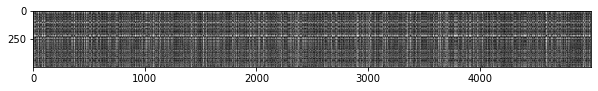

In [86]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question 1** 

Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

### What in the data is the cause behind the distinctly bright rows?

##### The bright rows represents a higher value of eucledian distance between the test image and the training data. This can occur because the image background or foreground is significatly different to that of the training image. Since the images are cropped close to the subject with less background data, we can attritube these significat changes to the foreground of the images. Thus bright lines indicate that the corresponding images are significatly different.

### What causes the columns?

##### The columns indicate the Eucledian distance values intensity of corresponding test image and the training data.




### Improving the distance computation algorithm

In [87]:
import time

# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    func to measure time taken
    """    
    t1 = time.time()
    f(*args)
    t2 = time.time()
    return t2 - t1

two_loop_time = time_function(classifier.compute_distances_two_loops, x_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, x_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, x_test)
print("You should see significantly faster performance with the fully vectorized implementation!")
print('No loop version took %f seconds' % no_loop_time)


Two loop version took 18.827715 seconds
One loop version took 30.831877 seconds
You should see significantly faster performance with the fully vectorized implementation!
No loop version took 0.284296 seconds


### Making predictions using test data

Case I : When K = 1

In [88]:
# predicting the test data
y_test_pred = classifier.predict_labels(dists, k=1)

test_data_len = y_test.shape[0]

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / test_data_len

print('Got %d / %d correct => Accuracy: %f percent' % (num_correct, test_data_len, accuracy*100))

Got 137 / 500 correct => Accuracy: 27.400000 percent


Case II : When K = 5

In [89]:
# predicting the test data
y_test_pred = classifier.predict_labels(dists, k=5)

test_data_len = y_test.shape[0]

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / test_data_len

print('Got %d / %d correct => Accuracy: %f percent' % (num_correct, test_data_len, accuracy*100))

Got 139 / 500 correct => Accuracy: 27.800000 percent


#### There is a slight improvement in the accuracy

## Testing the algorithm manually

/home/vaishanth/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  
/home/vaishanth/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Correctly Predicted Count: 8
Accuracy: 0.08


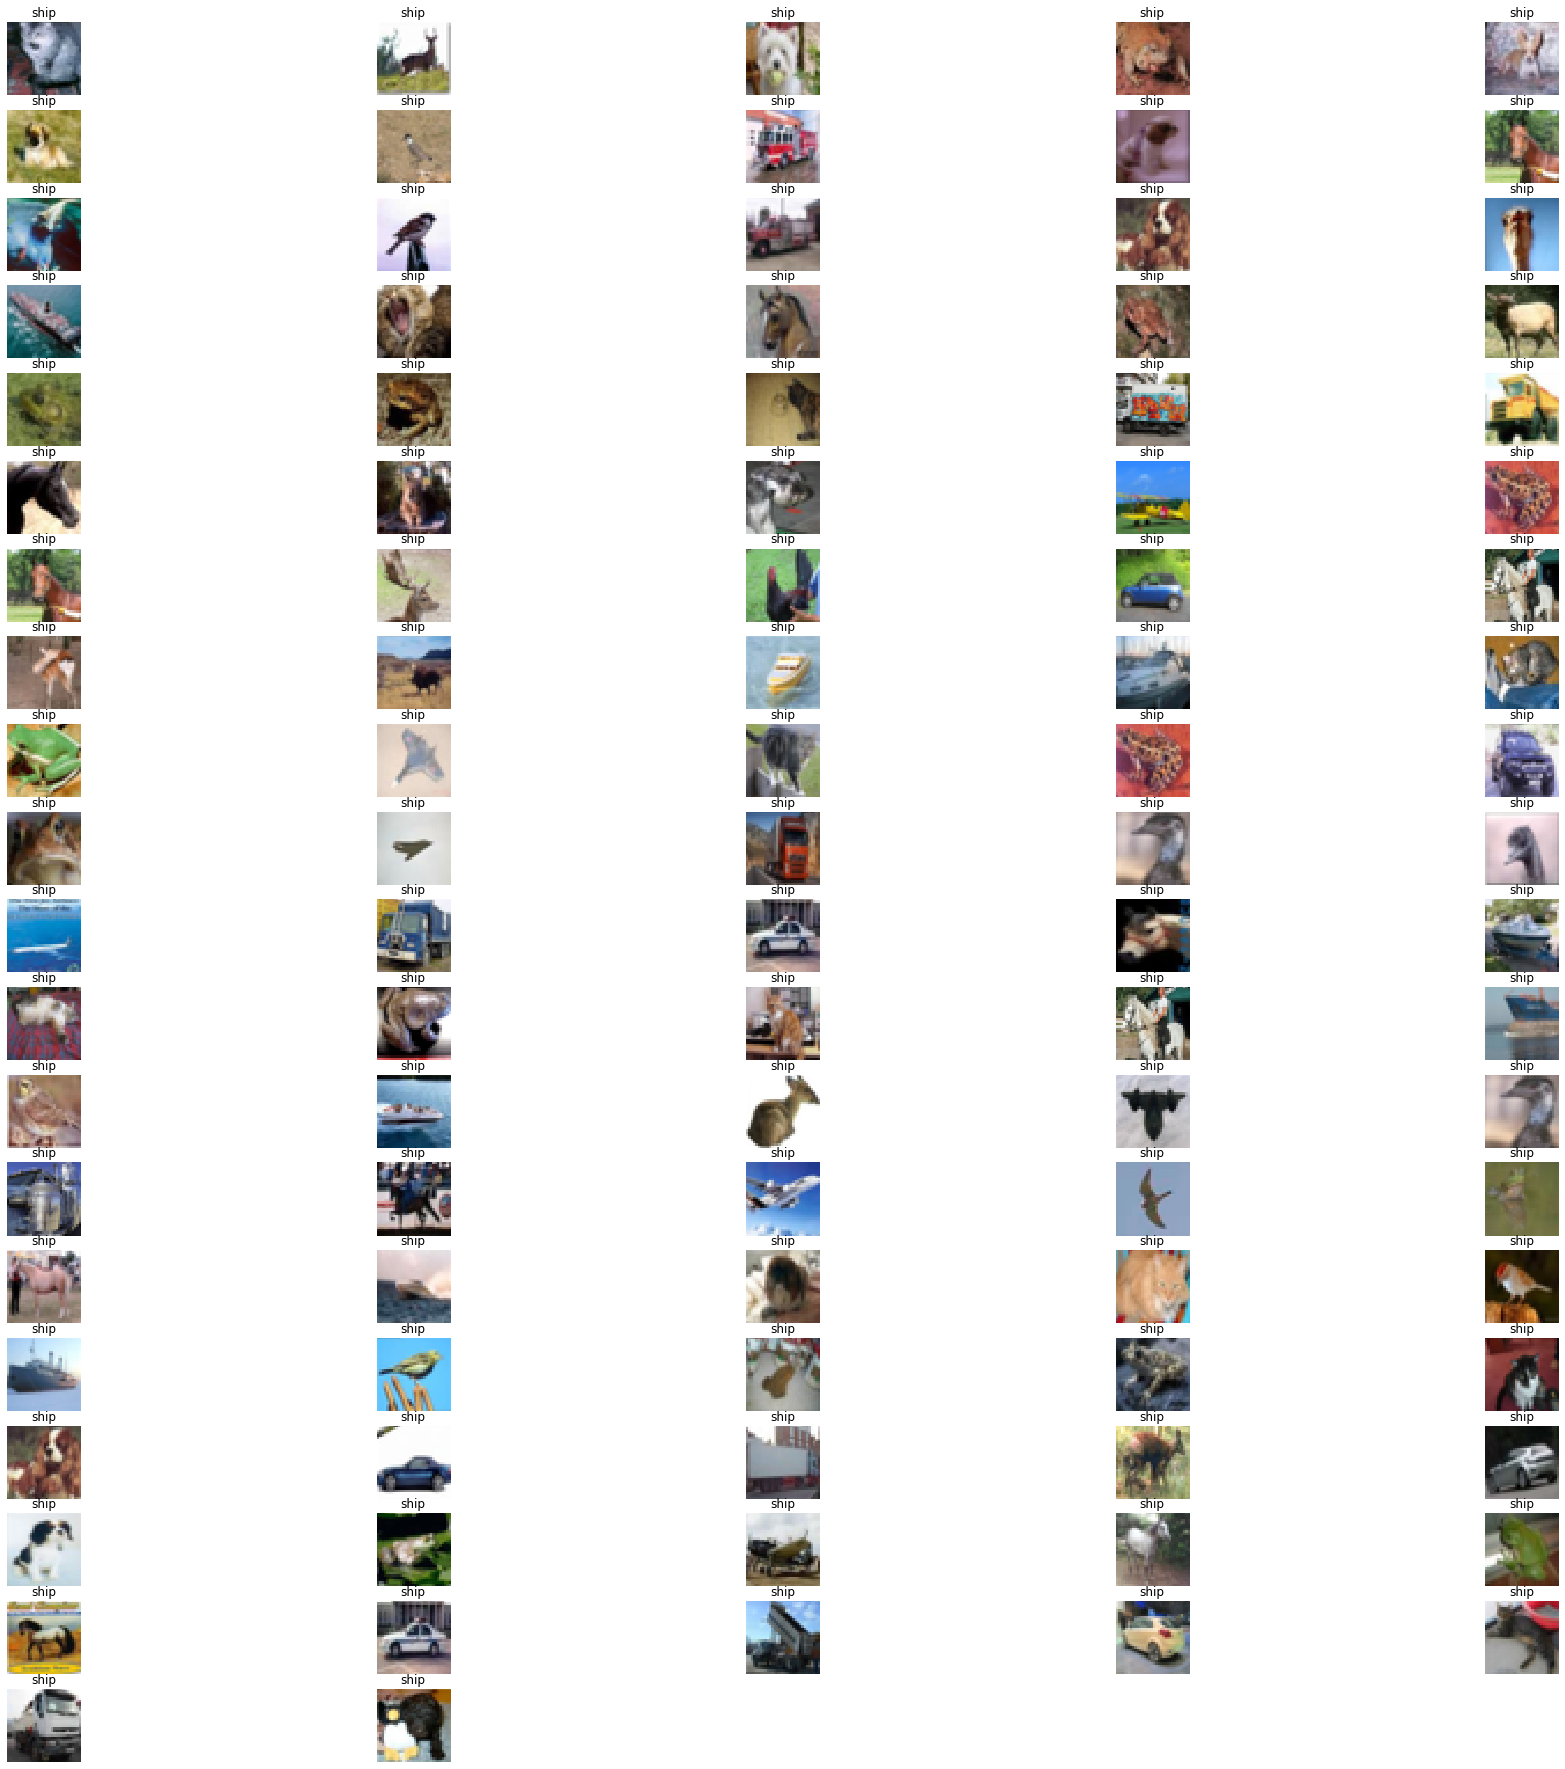

In [90]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

correctly_predicted_count = 0
plt.figure(figsize=(32, 32))
plt.tight_layout()
num_test_images = 100
for i in range(1, num_test_images-2):
    plt.subplot(num_test_images/5, 5, i)
    rand_image_id = np.random.randint(len(x_test))
    test_image_array = x_test[rand_image_id]

    predicted_label_id = classifier.predict_label(test_image_array, k=5)
    predicted_label = classes[predicted_label_id]

    if predicted_label_id == y_test[rand_image_id]:
        correctly_predicted_count  += 1

    test_image_array = test_image_array.reshape(32, 32, 3)
    
    plt.imshow(test_image_array.astype('uint8'))
    plt.axis('off')
    plt.subplot(num_test_images/5, 5, i).set_title(predicted_label)

print("Correctly Predicted Count:" , correctly_predicted_count)
print("Accuracy:", (correctly_predicted_count/num_test_images))
plt.show()

### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [91]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []

# splitting X and y data into 5 folds
X_train_folds = np.array_split(x_train, 5)
y_train_folds = np.array_split(y_train, 5)

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}

classifier = KNearestNeighbor()
# iterating through the K choices
for k in k_choices:
  
  accuracy_results = []
  print('Evaluating for K = %d' % (k))
  for iter in range(num_folds):  

    # combining 4 X and y folds, leaving 1 fold for validation
    X_train_folds_combined = np.concatenate(X_train_folds[:iter]+ X_train_folds[iter+1:])
    y_train_folds_combined = np.concatenate(y_train_folds[:iter]+ y_train_folds[iter+1:])

    # training the classifier on the combined folds data
    classifier.train(X_train_folds_combined, y_train_folds_combined)

    num_test = X_train_folds[iter].shape[0]
    # predicting using no loop function and using the validation fold data
    y_pred_fold = classifier.predict(X_train_folds[iter], k = k)

    # checking the accuracy of the ouput and appending it to an array
    num_correct = np.sum(y_pred_fold == y_train_folds[iter])
    accuracy = float(num_correct) / num_test
    accuracy_results.append(accuracy)  

  # saving the accuracy results to the dict
  k_to_accuracies[k] = accuracy_results


# Print out the computed accuracies
for k in sorted(k_to_accuracies):
  print("For k = %d, accuray =>" % (k, ), end=" ")
  for accuracy in k_to_accuracies[k]:
      print('%f' % (accuracy), end=" ")
  print("")

Evaluating for K = 1
Evaluating for K = 3
Evaluating for K = 5
Evaluating for K = 8
Evaluating for K = 10
Evaluating for K = 12
Evaluating for K = 15
Evaluating for K = 20
Evaluating for K = 50
Evaluating for K = 100
For k = 1, accuray => 0.263000 0.257000 0.264000 0.278000 0.266000 
For k = 3, accuray => 0.239000 0.249000 0.240000 0.266000 0.254000 
For k = 5, accuray => 0.248000 0.266000 0.280000 0.292000 0.280000 
For k = 8, accuray => 0.262000 0.282000 0.273000 0.290000 0.273000 
For k = 10, accuray => 0.265000 0.296000 0.276000 0.284000 0.280000 
For k = 12, accuray => 0.260000 0.295000 0.279000 0.283000 0.280000 
For k = 15, accuray => 0.252000 0.289000 0.278000 0.282000 0.274000 
For k = 20, accuray => 0.270000 0.279000 0.279000 0.282000 0.285000 
For k = 50, accuray => 0.271000 0.288000 0.278000 0.269000 0.266000 
For k = 100, accuray => 0.256000 0.270000 0.263000 0.256000 0.263000 


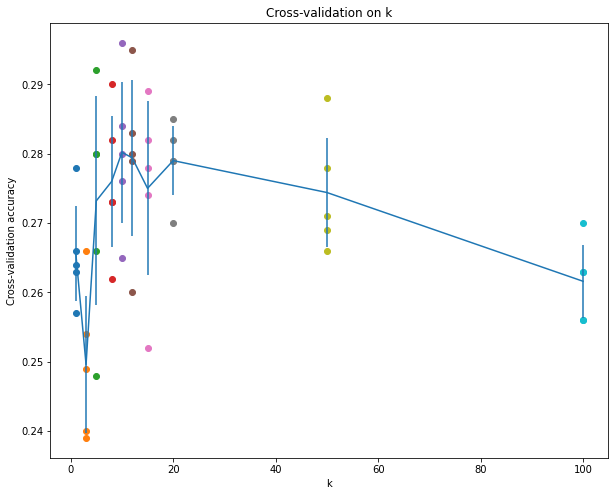

In [92]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [93]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.

# fecthing the best K from already computed accuracies_mean from the previous step
best_k = k_choices[accuracies_mean.argmax()]

classifier = KNearestNeighbor()
classifier.train(x_train, y_train)
y_test_pred = classifier.predict(x_test, k=best_k)

# Compute and display the accuracy
num_test = x_test.shape[0]
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000
